## 6-9. 프로젝트 : 주식 예측에 도전해 보자


## 1. 삼성전자 
 
 데이터는 과거의 일자별 시세. 삼성전자에 대한 주가를 예측해 보자.



In [1]:
# 주요 라이브러리 버전을 확인.
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


## STEP 1 : 시계열 데이터 준비

칼럼 종류 -  Date, Open,  High, Low, Close, Adj Close, Volume

날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인.종가만 사용.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행

In [3]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력 -> 결측치 없음 

Series([], Name: Close, dtype: float64)

In [4]:
# 로그 변환
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석

정성적 그래프 분석, 
정량적 Augmented Dicky-Fuller Test, 
시계열 분해(Time Series Decomposition),
Residual 안정성 확인.

이동평균(Moving Average. 혹은 Rolling Mean) : 시계열 데이터에서 특정 개수(d)의 데이터를 시점(t)을 이동하며 계산하는 평균.

이동표준편차(Rolling std) : 시계열 데이터에서 특정 개수(d)의 데이터를 시점(t)을 이동하며 계산하는 표준편차. (표준편차는 분산에 제곱근을 씌운 거)

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('1단계')

1단계 장착


In [6]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('2단계')

2단계 장착


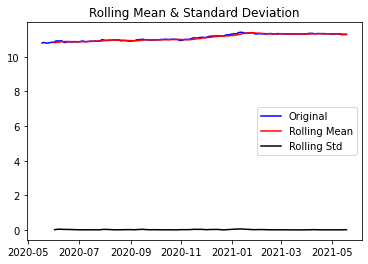

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


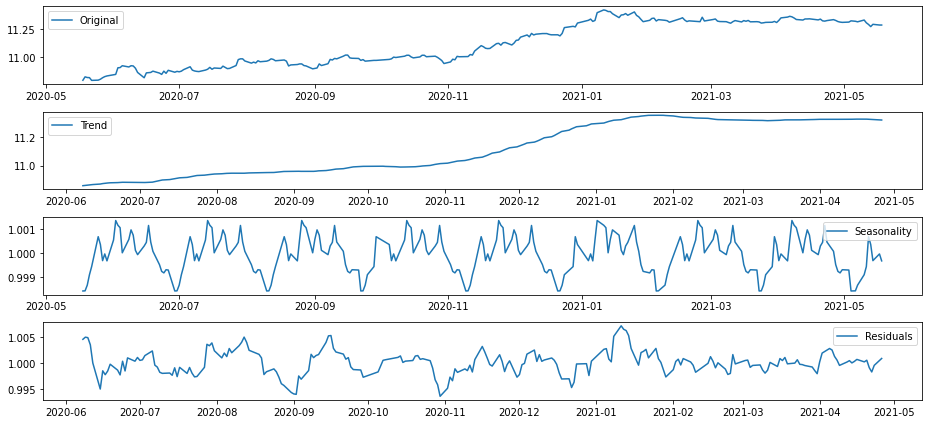

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend  # 시간에 따라 나타나는 평균값 변화
seasonal = decomposition.seasonal
residual = decomposition.resid # Original 시계열에서 Trend와 Seasonality를 뺀 나머지

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411) 
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### p-value                          0.59 나와 0.01이하로 더 떨어뜨려 정상성 시계열로 변환시켜야 함.



### 노드에서 복붙했더니 계속 define 안했다는 에러 떠서 
이동평균, 이동표준편차 시계열 2줄 넣고 겨우 에러 해결

*  rolmean = timeseries.rolling(window=window).mean()  
*  rolstd = timeseries.rolling(window=window).std()   










* Residual : Original 시계열에서 Trend와 Seasonality를 제거한 나머지. 이러한 Decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시.

In [8]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성

* 학습, 테스트 데이터셋 분리

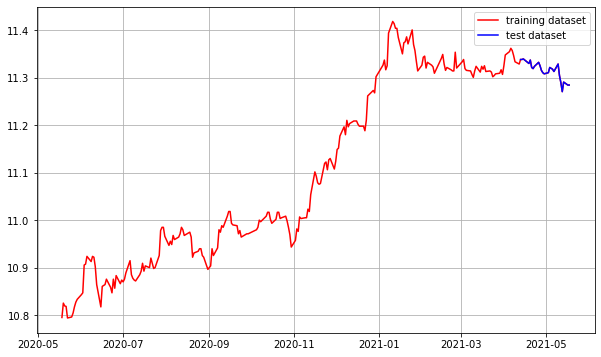

In [9]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


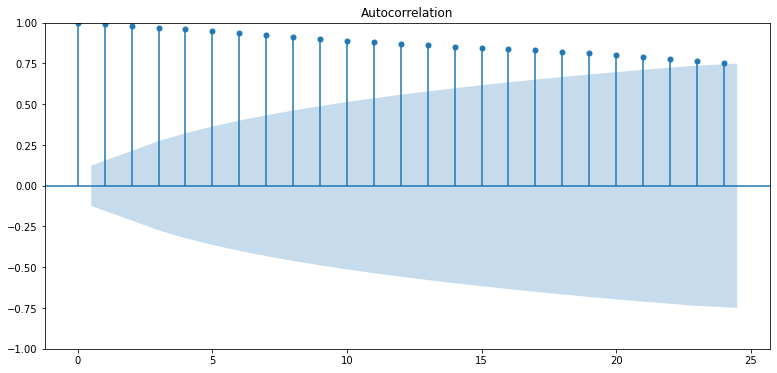

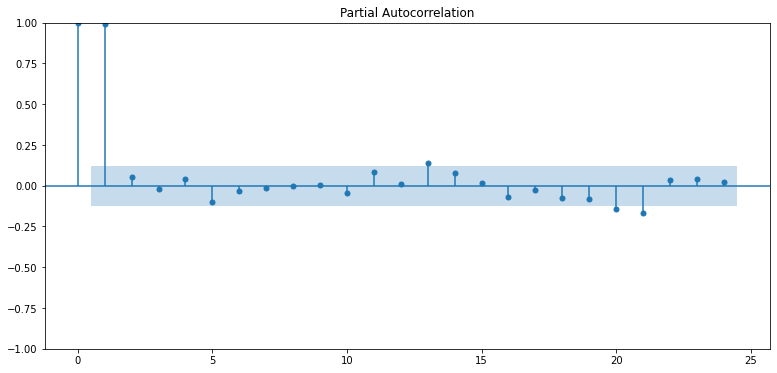

In [10]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

 ### ACF, PACF  그래프 분석
 
 * ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있음을 통계학적으로 설명.
 
 * ACF 그래프상 lag 1~22까지가 그림자 밖이라 유의미해 보임, 계속 미미하게라도 줄어드는 추이를 보여 q값에 0을 넣는게 낫다
 
 * PACF  p=1이 매우 적합한 듯. p가 2 이상~ 10인 구간에서 PACF는 거의 0에 가까워지고 있기 때문. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻. 반면 ACF는 점차적으로 감소하고 있어서 q에 대해서는 적합한 값이 없어 보임. MA를 고려할 필요가 없다면 q=0으로 둘 수 있다. 하지만 q를 바꿔 가면서 확인해 보는 것도 좋다.

* d를 구하기 위해서는 좀 다른 접근이 필요. d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 보아야한다 

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


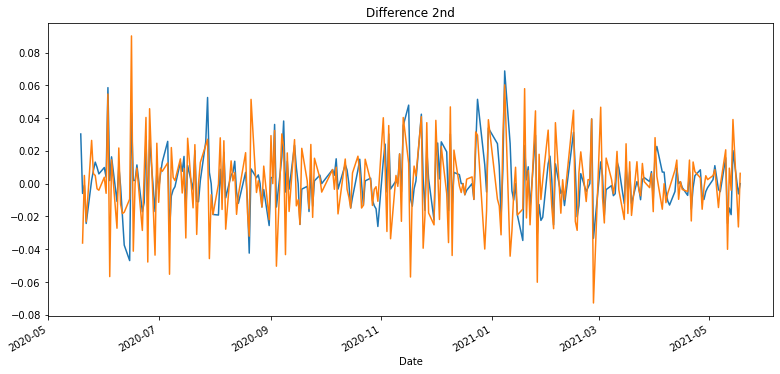

In [11]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)# 1차분 실행해보니 p-value가 2가 나와 2차분까지 돌렸는 오히려 3으로 더 올라감. n차분을 계속 더 해야하나? 더 올라갈수도

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트

* ARIMA 모델 빌드와 훈련, 모델 테스트 및 플로팅, 최종 예측 모델 정확도 측정(MAPE)

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Fri, 06 Jan 2023   AIC                          -1162.976
Time:                        13:12:30   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


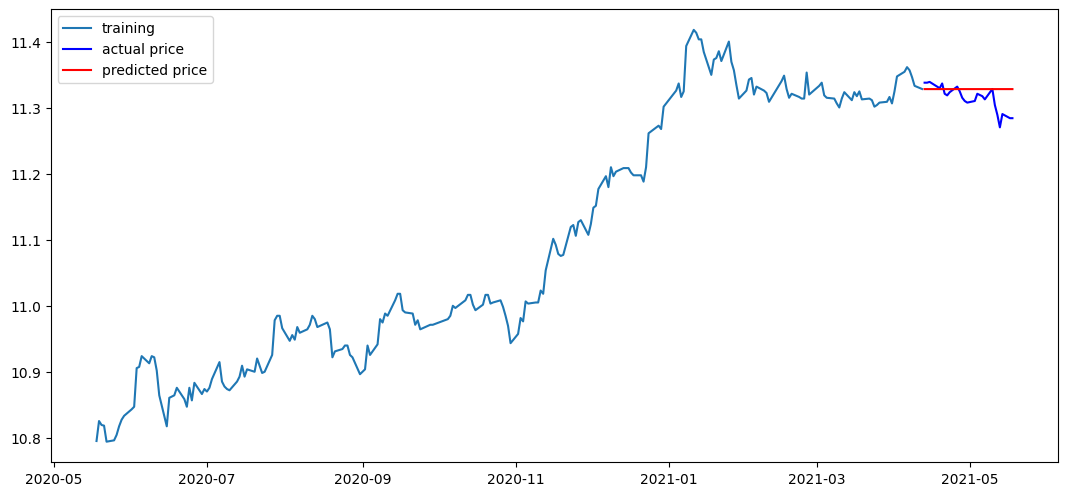

In [13]:
# Forecast : 결과가 fc에 담김. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(13,6), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

## 예측한 주가보다 실제주가가 더 낮게 나왔음. 이거믿고 주식거래하면 손실 보겠음.

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3480513.747715865
MAE:  1403.033723618997
RMSE:  1865.6135043775453
MAPE: 1.74%


##  (0, 1, 0)로 시도하니 좀더 낮아짐 .

In [15]:
model2 = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Fri, 06 Jan 2023   AIC                          -1162.976
Time:                        13:12:31   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


## AIC, BIC가 더 낮게 나오나 ? (2,0,1)도 시도.

In [16]:
model3 = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Fri, 06 Jan 2023   AIC                          -1162.976
Time:                        13:12:31   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


## (1, 1, 0)가   AIC, BIC 수치가 가장 좋아 model2, model3 말고 model로 MAPE 뽑아봄.

 * ACF, PACF 챠트상 분석한 수치 (1, 1, 0)이 AIC 수치가 가장 정상성 높은 시계열로 나타남.

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


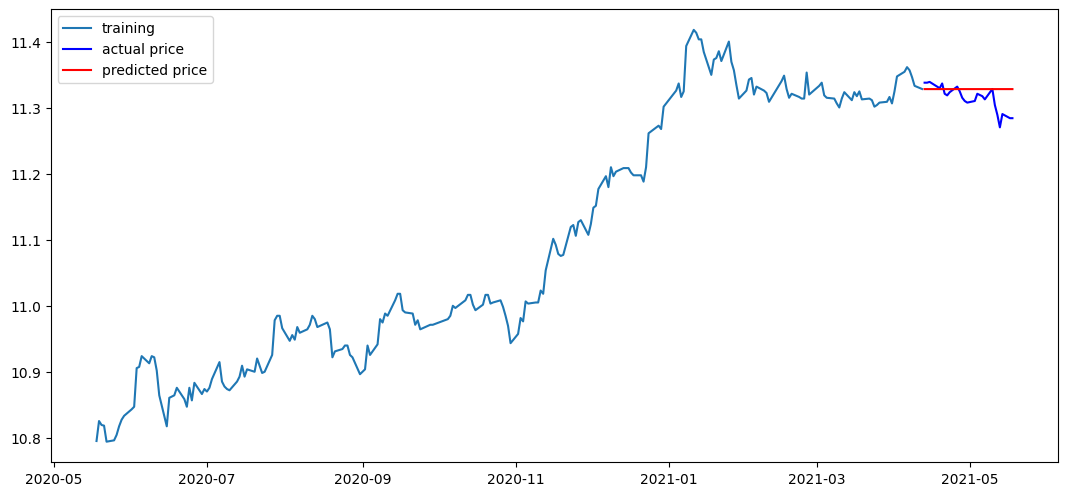

In [17]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)   

# Plot
plt.figure(figsize=(13,6), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3480513.747715865
MAE:  1403.033723618997
RMSE:  1865.6135043775453
MAPE: 1.74%


MAPE(mean absolute percentage error) : 퍼센트 값을 가지며 0에 가까울수록 회귀 모형의 성능이 좋다고 해석할 수 있음


## 2. McDonald 주가예측 

## STEP M1 : 시계열 데이터 준비

In [19]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/data/MCD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2022-01-05    267.190002
2022-01-06    269.690002
2022-01-07    267.059998
2022-01-10    264.410004
2022-01-11    262.119995
Name: Close, dtype: float64

## STEP M2 : 각종 전처리 수행

In [20]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  #  결측치 없음 

Series([], Name: Close, dtype: float64)

In [21]:
# 로그 변환
ts_log = np.log(ts)

## STEP M3 : 시계열 안정성 분석

In [22]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('1단계 장착')

1단계 장착


* statsmodels 패키지안에 adfuller 메서드¶
* statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석등의 기능을 파이썬에서도 이용할 수 있도록 하는 통계 패키지.

* adfuller 메서드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드.

In [23]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('2단계 장착')

2단계 장착


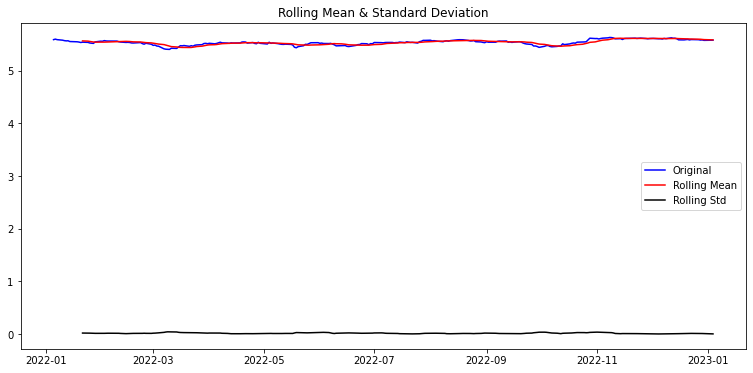

Results of Dickey-Fuller Test:
Test Statistic                  -2.090934
p-value                          0.248176
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


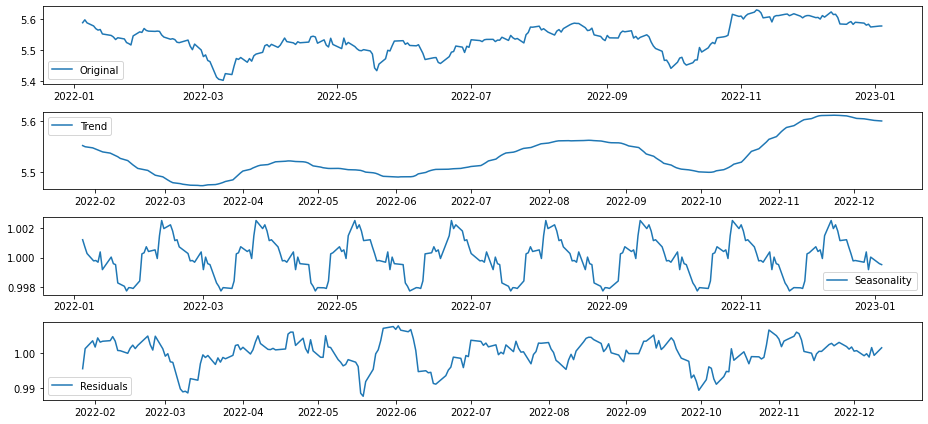

In [24]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend  # 시간에 따라 나타나는 평균값 변화
seasonal = decomposition.seasonal
residual = decomposition.resid # Original 시계열에서 Trend와 Seasonality를 뺀 나머지

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411) 
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### p-value가 0.2로 삼성전자  0.59보다 낮으나  더 떨어뜨려 정상성 시계열로 변환시켜야 함.


* Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지가 Residual. 이러한 Decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시.

* 이제 Residual에 대해 안정성 여부를 확인.

In [25]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.777587
p-value                          0.000060
#Lags Used                       2.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


### p-value                          0.00006로 상당히 낮음.

## STEP M4 : 학습, 테스트 데이터셋 생성

* 학습, 테스트 데이터셋 분리

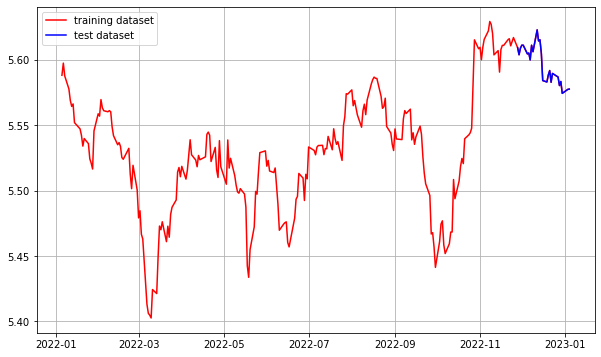

In [26]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP M5 : 적정 ARIMA 모수 찾기

* ACF, PACF 그려보기 -> p,q 구하기

* 차분 안정성 확인 -> d 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


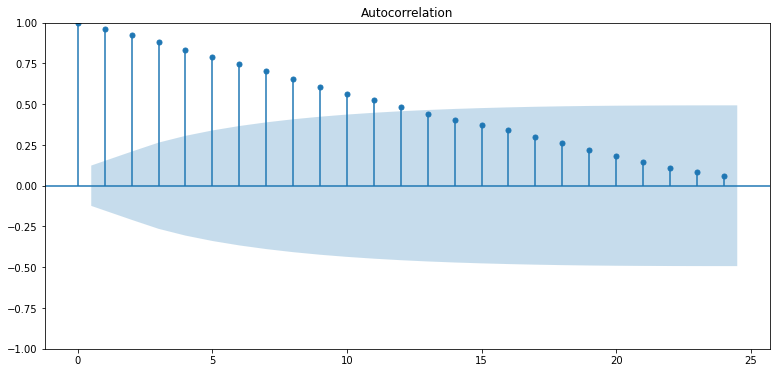

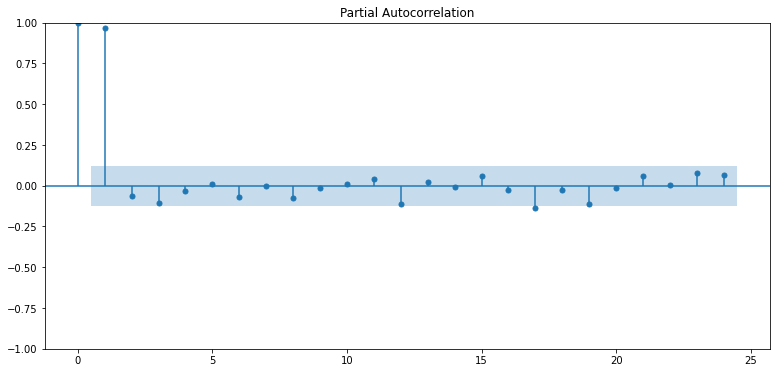

In [27]:
# ACF, PACF 그려 p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   
plot_pacf(ts_log)  
plt.show()

 ### ACF, PACF  그래프 분석
 
 
 * ACF 그래프상 lag 1~12까지가 그림자 밖이라 유의미해 보임, 계속 변동폭이 큰 상태가 아닌 경우엔 q값에 0을 넣는다
 
 * PACF 0인 자기상관외에 1값이 가장 높아  p=1이 매우 적합하다 상정. p가 2 이상~ 10인 구간에서 PACF는 거의 0에 가까워지고 있기 때문. MA를 고려할 필요가 없다면 q=0으로 둘 수 있다. 하지만 q를 바꿔 가면서 확인해 보는 것도 좋다.

 * d를 구하기 위해서는 좀 다른 접근이 필요. d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인.

Results of Dickey-Fuller Test:
Test Statistic                -9.894267e+00
p-value                        3.491595e-17
#Lags Used                     1.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.213617e+00
p-value                        6.715110e-13
#Lags Used                     9.000000e+00
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


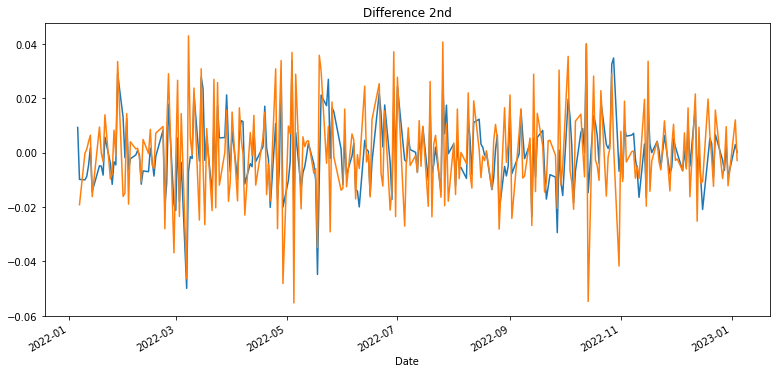

In [28]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### McDonald도 2차분하니 p-value가 3에서 6으로 더 올라가서 1차분 선택. 

## STEP M6 : ARIMA 모델 훈련과 테스트

* ARIMA 모델 빌드와 훈련, 모델 테스트 및 플로팅, 최종 예측 모델 정확도 측정(MAPE)

*  q를 바꿔가면서 시도하라고 하여 1로 바꿔 시도 

In [29]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 656.933
Date:                Fri, 06 Jan 2023   AIC                          -1307.867
Time:                        13:12:33   BIC                          -1297.632
Sample:                             0   HQIC                         -1303.735
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5298      0.692      0.766      0.444      -0.827       1.886
ma.L1         -0.4694      0.720     -0.652      0.514      -1.881       0.942
sigma2         0.0002   1.27e-05     13.061      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### 역시 ACF, PACF 그래프 분석으로 나온 p. d. q 수치 (1, 1, 0)가 AIC 수치가 -1162로 더 높게 나옴. 

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


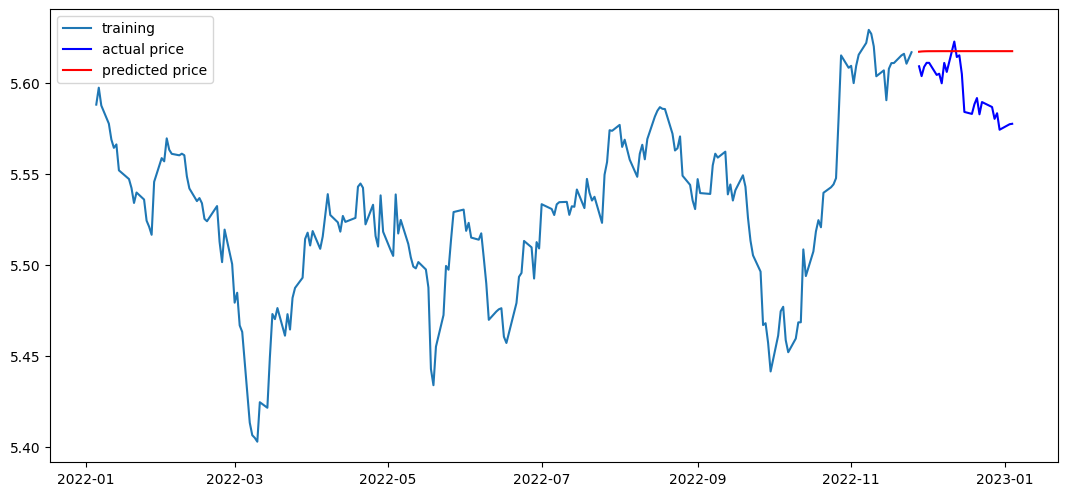

In [30]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)   

# Plot
plt.figure(figsize=(13,6), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

* 시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있다. np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산.

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  44.45424016337378
MAE:  5.612173335005535
RMSE:  6.667401305109344
MAPE: 2.10%


### p, d, q (1, 1, 0)이 AIC 수치가 가장 높게 나와 정상성 시계열 로 MAPE 2.1% 나왔음.









## 3. APPLE 주가 예측

## STEP A1 : 시계열 데이터 준비

In [61]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts1 = df['Close']

ts1.head()

Date
2022-01-05    174.919998
2022-01-06    172.000000
2022-01-07    172.169998
2022-01-10    172.190002
2022-01-11    175.080002
Name: Close, dtype: float64

## STEP A2 : 각종 전처리 수행

In [62]:
# 결측치 처리
ts1 = ts.interpolate(method='time')
ts1[ts1.isna()]  #  결측치 없음 

Series([], Name: Close, dtype: float64)

### 보다 Stationary한 시계열로 가공해 가는 방법 -1  로그함수로 변환


 * 시간추이에 따라 분산이 점점 커지고 있는 시계열엔 로그함수로 변환시킴.

In [63]:
# 로그 변환
ts1_log = np.log(ts1)

## STEP A3 : 시계열 안정성 분석

* 시계열 데이터의 통계적 특성을 좀 더 명료하게 시각화.

* 일정시간내 Rolling Statistics구간통계치를 시각화해 보는 함수.

* 구간의 평균(rolling mean, 이동평균)과 구간의 표준편차(rolling std, 이동표준편차)를 원본 시계열과 함께 시각화해 보면 더 뚜렷한 경향성을 확인.

* 이동평균(Moving Average. 혹은 Rolling Mean) : 시계열 데이터에서 특정 개수(d)의 데이터를 시점(t)을 이동하며 계산하는 평균.

* 이동표준편차(Rolling std) : 시계열 데이터에서 특정 개수(d)의 데이터를 시점(t)을 이동하며 계산하는 표준편차. (표준편차는 분산에 제곱근을 씌운 값)

In [56]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('1단계')

1단계 장착


### 로그 변환등의 효과가 어떠했는지 보기 위해 Augmented Dickey-Fuller Test를 수행

* Augmented Dickey-Fuller Test(ADF Test) : 시계열 데이터의 stationary안정성을 평가하고 테스트하는 보다 정량적, 통계적 방법.

* DF 검정에 p lag의 차분을 추가( ϕp∇yt−p)해 검정 능력을 더 강화시킴. t−p 시점까지의 차분 경향성을 파악할수 있어서 주기를 가진 데이터의 정상성 여부를 판단 ADF 검정의 귀무가설은 DF 검정과 귀무가설이 같으므로 검정통계량이 Critical Value보다 작거나 p-value가 설정한 유의수준 값보다 작으면 정상적인 시계열 데이터라고 볼수있다.

* p-value(probability value) : 유의확률은 실험의 표본 공간에서 정의되는 확률변수로, 0~1 사이의 값을 가진다. 이 값이 0.05 미만으로 매우 낮게 나온다면               p-value만큼의 오류 가능성 하에 귀무가설을 기각하고 대립가설을 채택할 수 있는 근거. 


In [57]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('2단계')

2단계 장착




###  보다 Stationary한 시계열로 가공해 가는 방법 -2. Moving average 제거 - 추세(Trend) 상쇄하기¶


* 시간 추이에 따른 평균값변화, 추세(trend). 이 변화량을 제거해 주려면 거꾸로 Moving Average, 즉 rolling mean을 구해서 상쇄 시도.
rolling statistics를 추가해서 시각화해봄

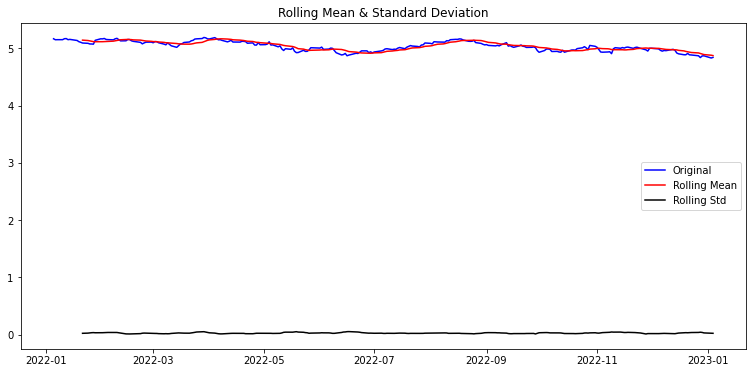

Results of Dickey-Fuller Test:
Test Statistic                  -1.730920
p-value                          0.415256
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


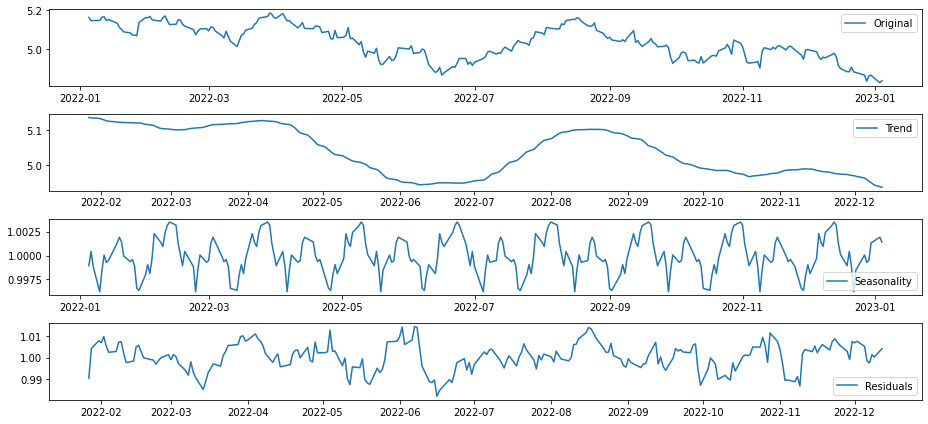

In [64]:
# 정성적 그래프 분석
plot_rolling_statistics(ts1_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts1_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts1_log, model='multiplicative', period = 30) 

trend = decomposition.trend  # 시간에 따라 나타나는 평균값의 변화
seasonal = decomposition.seasonal
residual = decomposition.resid # Original 시계열에서 Trend와 Seasonality를 뺀 나머지

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411) 
plt.plot(ts1_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

* 이 데이터셋은 2개월 단위로 발생하는 시계열이므로 12개월 단위로 주기성이 있다면 window=12가 적당할것 같으나 moving average감안 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요.

* 이제 시간의 추이에 따라 평균이 증가하는 trend를 제거됨.

* Differencing차분 - 계절성(Seasonality) 상쇄하기 Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소. 이것은 Moving Average 제거로는 상쇄되지 않는 효과입니다. 계절성포함 이런 주기적 패턴도 계절성.

* 추세 (Trend) :시계열에서 기울기가 증가하거나 감소할 때 관찰. 일정시간 발생했다가 사라지고 반복되지X. 계절성 (Seasonality) : 혹은 일정 기간 안에 반복적으로 나타나는 패턴. 주기성 (Cycle) : 정해지지 않은 빈도, 기간으로 일어나는 상승 혹은 하락을 의미.

* 이런 패턴을 상쇄하기 위해 차분. 마치 미분(Differentiation)스런 개념, 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법 Q 뭔얘기? 이렇게 되면 남은 것은 현재 스텝 값 - 직전 스텝 값이 되어 정확히 이번 스텝에서 발생한 변화량을 의미. 우선 시프트한 시계열과 원본 시계열에 대한 그래프를 그려보면.

In [65]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.552087
p-value                          0.000002
#Lags Used                       0.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


### p-value                          0.00006로 너무 낮음.

## STEP A4 : 학습, 테스트 데이터셋 생성

* 학습, 테스트 데이터셋 분리

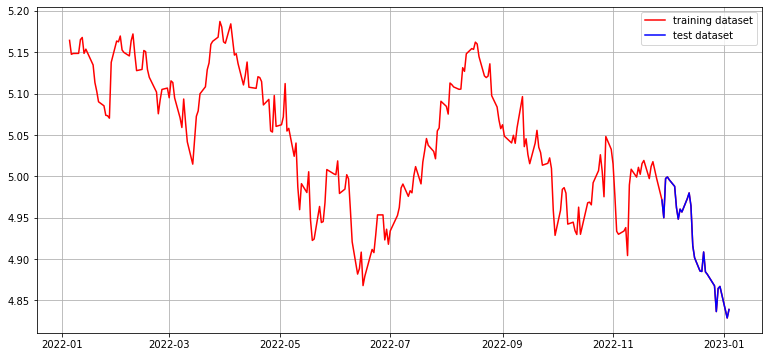

In [66]:
train_data, test_data = ts1_log[:int(len(ts1_log)*0.9)], ts1_log[int(len(ts1_log)*0.9):]
plt.figure(figsize=(13,6))
plt.grid(True)
plt.plot(ts1_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP A5 : 적정 ARIMA 모수 찾기¶

* ACF, PACF 그려보기 -> p,q 구하기 차분 안정성 확인 -> d 구하기


### Time series decomposition 시계열 분해 

* statsmodels 라이브러리 안에는 seasonal_decompose 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼수있는 기능.
이 기능을 활용하면  moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼수있다. 
위에서 구했던 로그변환 단계(ts_log)에서부터 출발.


* statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석등의 기능을 파이썬에서도 이용할 수 있도록 하는 통계 패키지. 


* adfuller 메서드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드.




/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


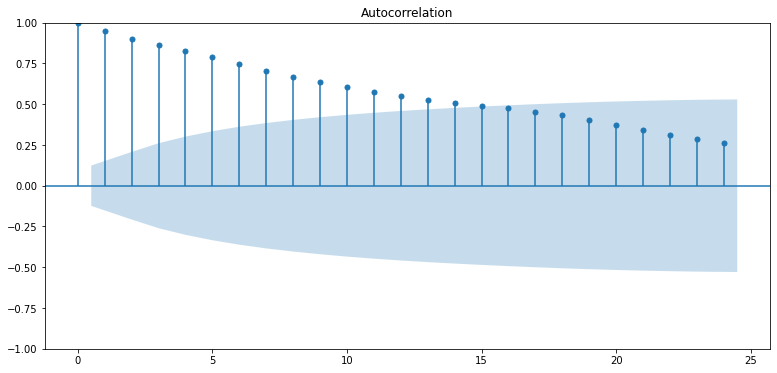

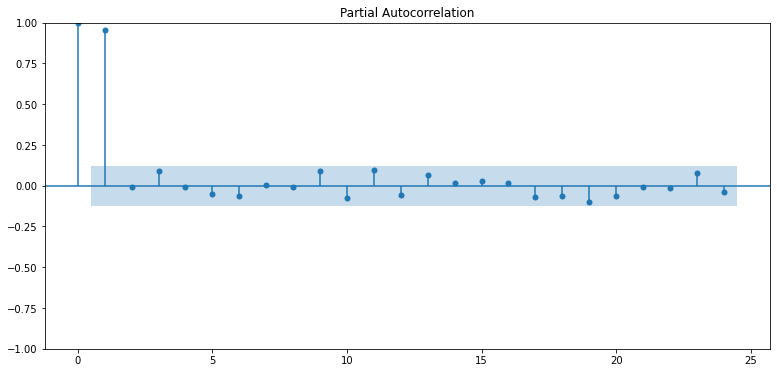

In [67]:
# ACF, PACF 그려 p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts1_log)   
plot_pacf(ts1_log)  
plt.show()

### ACF, PACF 그래프 분석

* ACF 그래프상 lag 1~12까지가 그림자 밖이라 유의미해 보임, 계속 변동폭이 큰 상태가 아닌 경우엔 q값에 0을 넣는다

* PACF 0인 자기상관외에 1값이 가장 높아 p=1이 매우 적합하다 상정. p가 2 이상~ 10인 구간에서 PACF는 거의 0에 가까워지고 있기 때문. MA를 고려할 필요가 없다면 q=0으로 둘 수 있다. 하지만 q를 바꿔 가면서 확인해 보는 것도 좋다.

* d를 구하기 위해서는 좀 다른 접근이 필요. d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인.

* 차분의 효과가 어떠했는지 알아보기 위해 Augmented Dickey-Fuller Test를 수행.

Results of Dickey-Fuller Test:
Test Statistic                -1.238601e+01
p-value                        4.907699e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.898497e+00
p-value                        4.247080e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


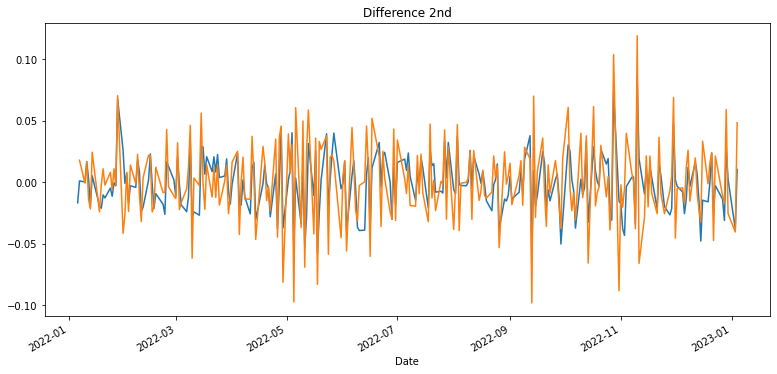

In [68]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts1_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### McDonald와 동일하게 2차분하니 p-value가 더 올라가서 1차분 선택. 

## STEP A6 : ARIMA 모델 훈련과 테스트

* ARIMA 모델 빌드와 훈련, 모델 테스트 및 플로팅, 최종 예측 모델 정확도 측정(MAPE)

In [69]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 531.704
Date:                Fri, 06 Jan 2023   AIC                          -1059.408
Time:                        13:28:29   BIC                          -1052.584
Sample:                             0   HQIC                         -1056.653
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0376      0.065     -0.579      0.563      -0.165       0.090
sigma2         0.0005   4.37e-05     11.628      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


* q를 바꿔가면서 최적의 모수를 찾기위해 1로 바꿔 시도 

In [70]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 532.131
Date:                Fri, 06 Jan 2023   AIC                          -1058.262
Time:                        13:29:12   BIC                          -1048.027
Sample:                             0   HQIC                         -1054.131
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7961      0.306      2.601      0.009       0.196       1.396
ma.L1         -0.8399      0.271     -3.096      0.002      -1.372      -0.308
sigma2         0.0005   4.35e-05     11.634      0.0

### 역시 ACF, PACF 그래프 분석으로 나온 p. d. q 수치 (1, 1, 0)가 AIC 수치가 -1162로 더 높게 나옴. 

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


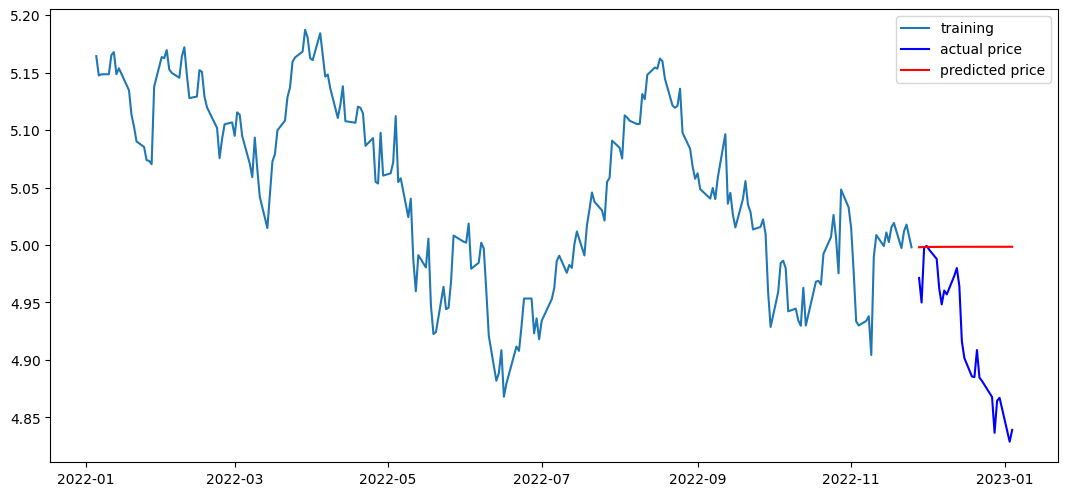

In [71]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)   

# Plot
plt.figure(figsize=(13,6), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  164.4639555680173
MAE:  10.482823809633846
RMSE:  12.824350103144303
MAPE: 7.93%


###  AIC 수치는 가장 적게 나오고 MAPE는 2.1%가 나온 p, d, q (1, 1, 0)이 가장 정상성 시계열로 판단됨.  





## Referrence

https://ko.wikipedia.org/wiki/%EC%9C%A0%EC%9D%98_%ED%99%95%EB%A5%A0

https://infuture.kr/426

https://acdongpgm.tistory.com/102

https://rk1993.tistory.com/entry/AIC-BIC-Mallows-Cp-%EC%89%BD%EA%B2%8C-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0


## 회고

- '12개월 단위로 주기성이 있는 시계열 데이터는 window=12가 적당할것 같으나 moving average감안 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요하다' 했는데  Apple 데이터셋은 2개월 단위로 발생하는 시계열인듯 그래프상 2개월 단위의 주기성도 모호한데 window=6이 적절한지 잘 모르겠고  여러 시계열 데이터들을 적용을 해봐야 감이 생길것 같음.


- 원본 시계열에서 시프트(rolmean 이동평균, rolstd 이동표준편차)한 시계열을 빼는 처리로 변동폭 줄고 왜 그래프상 평평해지는지 ? 수학적 base가 미천해서 이런지점에서 이해력이 안따라준다. 시간 날때 관련 수학내용 좀 보고 생각 좀 해봐야겠다. 
    

- 주가가 덜 폭락한 종목인 McDonald, Apple를 선택했는데  ACF, PACF 그래프 모양과 수치등이 너무 유사해 코드에 오류가 있나 점검하는데 시간소모가 많았다.
  
